In [1]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [2]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [3]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [4]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [5]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    print(y_true.get_label())
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # y_true.get_label().shape=(2025, )
    # y_pred.shape=(2025 *7, )
    # reshape_y_pred.shape=(2025, 7)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [6]:
evals_result = {}  # 储存评估指标(内置和自定义)结果
re_func = lgb.record_evaluation(eval_result=evals_result)
es_func = lgb.early_stopping(stopping_rounds=200)
le_func = lgb.log_evaluation(100)

params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]

model = lgb.train(params=params,
                  train_set=train_dataset,
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  callbacks=[re_func, es_func, le_func],
                  num_boost_round=200,  # 默认num_boost_round=1000
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

[4. 0. 3. ... 1. 1. 4.]
[2. 4. 4. 0. 5. 1. 4. 0. 0. 2. 0. 0. 2. 4. 1. 4. 1. 1. 1. 4. 1. 2. 4. 4.
 6. 4. 5. 6. 1. 4. 1. 3. 1. 2. 5. 0. 4. 4. 1. 1. 1. 1. 4. 1. 2. 0. 1. 1.
 0. 4. 2. 2. 1. 6. 0. 4. 1. 5. 4. 5. 1. 1. 4. 0. 4. 4. 4. 2. 3. 5. 0. 4.
 5. 4. 2. 0. 4. 1. 1. 4. 0. 0. 3. 3. 6. 4. 4. 3. 1. 6. 0. 0. 1. 4. 1. 4.
 6. 4. 1. 1. 0. 1. 4. 1. 4. 1. 4. 4. 4. 4. 1. 2. 1. 5. 5. 3. 5. 1. 4. 0.
 0. 4. 0. 2. 4. 0. 0. 2. 1. 4. 1. 4. 2. 4. 4. 0. 3. 1. 1. 1. 2. 4. 4. 0.
 1. 4. 4. 1. 4. 2. 2. 4. 4. 5. 0. 1. 4. 5. 3. 4. 0. 5. 4. 1. 0. 0. 1. 3.
 0. 0. 1. 1. 0. 4. 5. 1. 0. 0. 0. 5. 0. 4. 6. 4. 2. 0. 5. 0. 4. 1. 4. 0.
 5. 4. 3. 1. 1. 0. 4. 4. 2. 2. 5. 0. 5. 5. 1. 4. 6. 0. 1. 1. 1. 1. 5. 4.
 1. 0. 0. 4. 0. 4. 1. 1. 4. 1. 2. 3. 1. 2. 2. 1. 4. 5. 4. 4. 2. 4. 2. 0.
 1. 4. 0. 1. 4. 0. 5. 1. 2. 4. 0. 1. 1. 5. 1. 1. 6. 4. 1. 1. 4. 0. 4. 1.
 1. 4. 5. 2. 5. 1. 4. 3. 6. 2. 4. 0. 1. 0. 2. 4. 6. 4. 5. 4. 1. 1. 4. 0.
 5. 2. 1. 0. 1. 5. 1. 1. 0. 0. 4. 4. 4. 3. 3. 5. 1. 1. 5. 1. 1. 1. 6. 5.
 1. 5. 1. 4. 0. 5. 6. 1. 2.

array([[4.60855865e-10, 1.10674432e-05, 4.77751364e-11, ...,
        9.99988932e-01, 2.75278855e-11, 2.67252922e-11],
       [2.56440322e-11, 7.20043302e-08, 9.72004347e-12, ...,
        9.99999928e-01, 7.58054641e-12, 3.94587218e-12],
       [9.99329628e-01, 6.70332324e-04, 5.99782136e-09, ...,
        1.42378649e-08, 6.95933289e-09, 6.22456941e-09],
       ...,
       [3.34422018e-08, 1.28447182e-04, 1.77114027e-09, ...,
        9.99871428e-01, 6.97346673e-10, 6.43228297e-10],
       [9.99548993e-01, 4.48931347e-04, 2.74014589e-08, ...,
        1.73300724e-06, 2.50947560e-08, 9.57886948e-08],
       [3.02881587e-11, 5.12694836e-08, 2.43565438e-11, ...,
        9.99999949e-01, 7.20290149e-12, 4.62028187e-12]])

In [7]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 6.799828328899804e-05),
                          ('MY_GBM_LOSS', 6.799828328899267e-05)]),
             'valid_1': OrderedDict([('multi_logloss', 0.7590145816375551),
                          ('MY_GBM_LOSS', 0.7590145816375551)])})

In [8]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.331632305492875,
                1.138637742562153,
                0.9908430011806166,
                0.8775894372406805,
                0.782844388891961,
                0.7029765359631728,
                0.634771697136567,
                0.5756178600942811,
                0.5249762558739322,
                0.48064496753271735,
                0.4395084346542287,
                0.4050274147359044,
                0.37433122681582526,
                0.3465750790690581,
                0.3216340482900684,
                0.2981602083778787,
                0.277556031471905,
                0.2582053556021447,
                0.24159840442693575,
                0.2243155856202397,
                0.20966049868068506,
                0.19607090100202912,
                0.18341683211590096,
                0.17230895662906326,
                0.16199311617080198,
                0.15266281911373977,
                

In [9]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

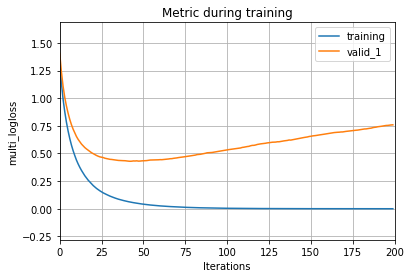

In [10]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

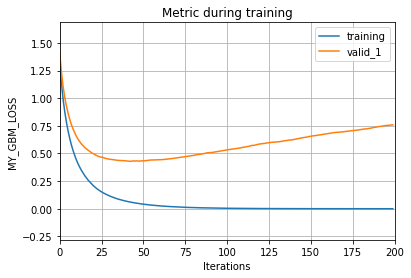

In [11]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [12]:
# 特征的相对重要性
model.feature_importance()

array([5284, 2628, 1607, 2804, 2734, 4695, 2208, 2258, 2095, 4988,  288,
          0,  134,   25,  120,   35,    0,    0,   35,    0,    0,    0,
          0,  124,    0,  194,  105,    0,    0,    0,   63,   33,   43,
        288,    0,   50,  146,   24,    0,    0,    0,    0,  344,  260,
         12,   24,   46,    0,    0,    0,    0,  109,   65,    0])

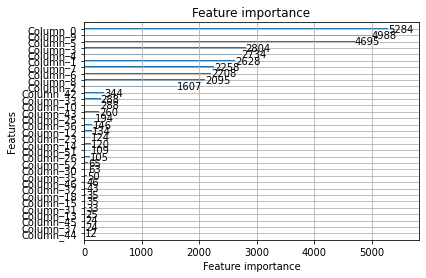

In [13]:
# 绘制特征的相对重要性
lgb.plot_importance(model)
plt.show()

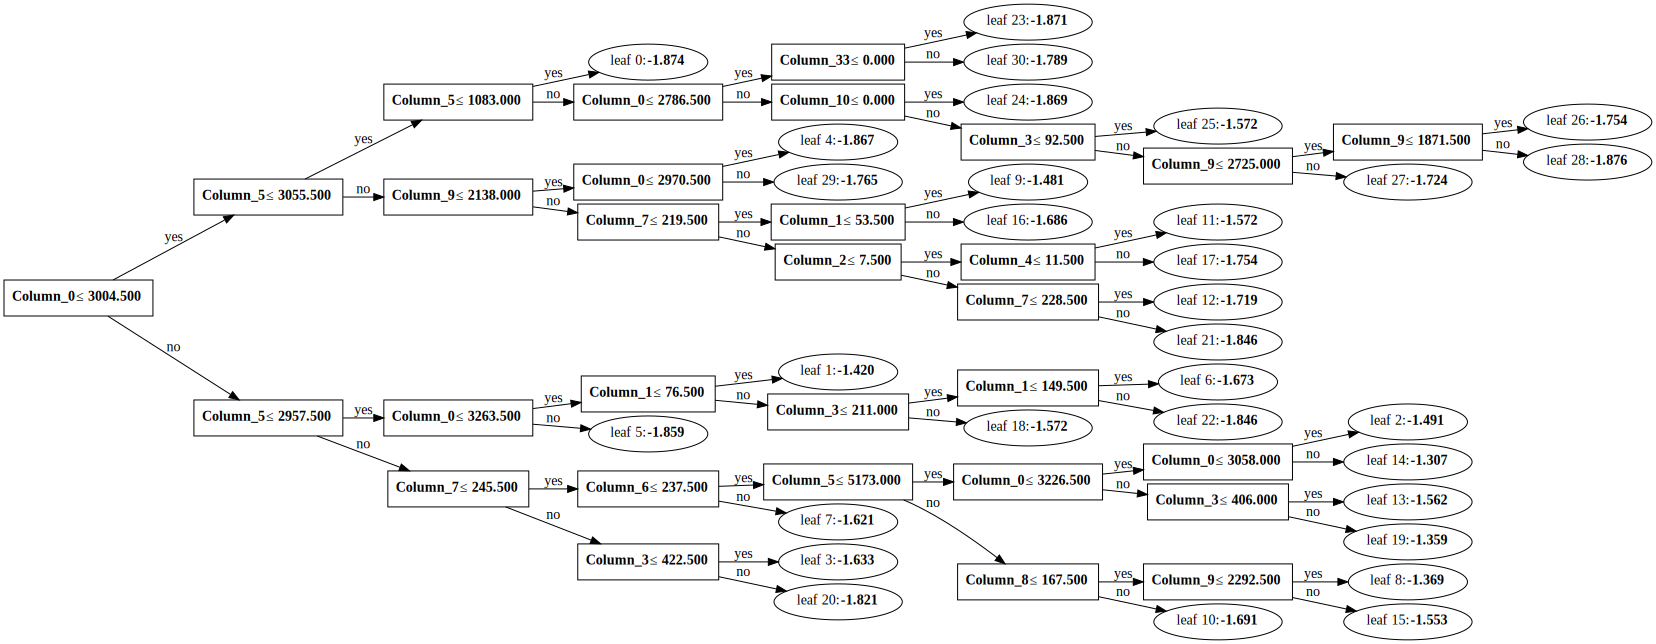

In [14]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [15]:
# 数据类型为graphviz.dot.Digraph
type(img)

graphviz.graphs.Digraph

In [16]:
# 图保存
# 可对img_view.gv中的数据进行解析
img.view(filename="img_view.gv")

'img_view.gv.pdf'

In [22]:
'''
The returned DataFrame has the following columns.
    - ``tree_index`` : int64, which tree a node belongs to. 0-based, so a value of ``6``, for example, means "this node is in the 7th tree".
    - ``node_depth`` : int64, how far a node is from the root of the tree. The root node has a value of ``1``, its direct children are ``2``, etc.
    - ``node_index`` : str, unique identifier for a node.
    - ``left_child`` : str, ``node_index`` of the child node to the left of a split. ``None`` for leaf nodes.
    - ``right_child`` : str, ``node_index`` of the child node to the right of a split. ``None`` for leaf nodes.
    - ``parent_index`` : str, ``node_index`` of this node's parent. ``None`` for the root node.
    - ``split_feature`` : str, name of the feature used for splitting. ``None`` for leaf nodes.
    - ``split_gain`` : float64, gain from adding this split to the tree. ``NaN`` for leaf nodes.
    - ``threshold`` : float64, value of the feature used to decide which side of the split a record will go down. ``NaN`` for leaf nodes.
    - ``decision_type`` : str, logical operator describing how to compare a value to ``threshold``.
        For example, ``split_feature = "Column_10", threshold = 15, decision_type = "<="`` means that
        records where ``Column_10 <= 15`` follow the left side of the split, otherwise follows the right side of the split. ``None`` for leaf nodes.
    - ``missing_direction`` : str, split direction that missing values should go to. ``None`` for leaf nodes.
    - ``missing_type`` : str, describes what types of values are treated as missing.
    - ``value`` : float64, predicted value for this leaf node, multiplied by the learning rate.
    - ``weight`` : float64 or int64, sum of hessian (second-order derivative of objective), summed over observations that fall in this node.
    - ``count`` : int64, number of records in the training data that fall into this node.
'''
df = model.trees_to_dataframe()
df.head()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S3,0-S1,None,Column_0,543.708984,3004.5,<=,left,None,-1.772680,0.000000,2025
1,0,2,0-S3,0-S22,0-S8,0-S0,Column_5,46.892899,3055.5,<=,left,None,-1.842430,256.654000,1560
2,0,3,0-S22,0-L0,0-S23,0-S3,Column_5,4.918690,1083.0,<=,left,None,-1.862990,208.449000,1267
3,0,4,0-L0,None,None,0-S22,None,NaN,NaN,None,None,None,-1.874445,133.920574,814
4,0,4,0-S23,0-S29,0-S24,0-S22,Column_0,5.053490,2786.5,<=,left,None,-1.842390,74.528300,453


In [24]:
# 决策路径
df[df['tree_index'] == 0]

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S3,0-S1,None,Column_0,543.708984,3004.5,<=,left,None,-1.772680,0.000000,2025
1,0,2,0-S3,0-S22,0-S8,0-S0,Column_5,46.892899,3055.5,<=,left,None,-1.842430,256.654000,1560
2,0,3,0-S22,0-L0,0-S23,0-S3,Column_5,4.918690,1083.0,<=,left,None,-1.862990,208.449000,1267
3,0,4,0-L0,None,None,0-S22,None,NaN,NaN,None,None,None,-1.874445,133.920574,814
4,0,4,0-S23,0-S29,0-S24,0-S22,Column_0,5.053490,2786.5,<=,left,None,-1.842390,74.528300,453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,7,0-L10,None,None,0-S9,None,NaN,NaN,None,None,None,-1.690949,3.783997,23
57,0,5,0-L7,None,None,0-S6,None,NaN,NaN,None,None,None,-1.621045,5.100169,31
58,0,4,0-S19,0-L3,0-L20,0-S2,Column_3,6.083490,422.5,<=,left,None,-1.731220,6.909910,42
59,0,5,0-L3,None,None,0-S19,None,NaN,NaN,None,None,None,-1.632809,3.290432,20
